# Drug-Drug Similarity Based on the Taxonomy 


                                                                                by Alberto Olivares Alarcos

This notebook gives a flavour of how to obtain a measurement of similarity between pairs of drugs by considering their taxonomic structure. The measurement is computed the distance between a pair of drugs in the taxonomy we find within the database, DrugBank$^{[1]}$. Then, a similiarity matrix is calculated using the Leacock and Chodorow method. The similarity matrix is used to cluster the drugs into 14 groups. An evaluation of those obtained clusters is done at the end of the experiment. 

Note that any time we talk about similarity, we are also talking about distance, since we can obtain one from the another one just substracting one of them to the unit (e.g. the similarity is one minus the distance, and vice-versa).

[1] *The DrugBank database is a comprehensive, freely accessible, online database containing information on drugs and drug targets. For more information visit: https://www.drugbank.ca/.*

## Experimental Setup

As said above, in this work we are going to compute a measure of similarity among drugs extracted from the Drugbank database. Our aim is to show how this measure could be useful, so that we use it to cluster the drugs. In this section, we explain the main parts of our experiment and the decision making done when choosing the tools used within this work. 

### Why building a graph?

The Drugank database contains a field named "Classification" which structures the data as a graph (taxonomy) with different levels. Therefore, taxonomy contains implicit information about the similarity of the drugs we can use for our purpose. 

The classification has 5 in total levels, enumerated from the highest to the lowest:
- Kingdom - Organic or Inorganic
- Classes - drug classes form the major component of the classification system. Drugs with the same class are considered structurally similar.

The Classes are divided into:
- SuperClass, for example - ”Organic Acids”
- Class, for example - ”Carboxylic Acids and Derivatives”
- SubClass, for example - ”Amino Acids, Peptides, and Analogues”
- DirectParent, for example - ”Peptides” (can coincide with SubClass)


### Drugs representation

The aim of this experiment is to compute the similarity between drugs using the graph structure in which they are organised. Thus, it is logically inevitable for us to build a graph in which the nodes are the drugs and the edges are the relationship between them. The semantics of our taxonomy is quite simple, the only relationship we are going to use is the *'is-a'* relationship, (e.g. Acetaminophen *is-a* SubClass of Benzenoids, or which is the same, Benzenoids *is-a* SuperClass of Acetaminophen).


We have used the classification tag in the Drugbank database to construct 2 trees of 5 levels which would connect the drugs in the database through undirected edges. Two different cases were contemplated: unweighted and weighted graphs. On the one hand, in unweighted graphs all the edges have the same meaning and value. On the other hand, in weighted graphs the cost of moving from one node to another is different depending on the level of the taxonomy in which the nodes are. This is to say, the edges between levels of the taxonomy imply a higher cost than edges between the same level. 

The distance between drugs is calculated as a shortest path distance. For the case of the weighted graph, the higher the level of the closest common ancestor in the tree, the higher the weight for the distance. The motivation behind having two trees instead of one is because the drugs belong to either Organic or Inorganic kingdom, so we have not contemplated the most general class 'Drug'. Thus, we have decided that the path between these kingdoms should not exist, because of the very nature of the taxonomy (no or very little information gain). Additionally, introducing full connectivity (any drug can be reached from any drug in the database) by adding a common root drastically increases computation time.

### Similarity measurement

Once we have a graph, we can compute the distance between every pair of drugs as the lenght of the path between them. In the cases in which there is no path, we set the distance to -1. There exist several ways of turning those distances into similarities though, we have chosen the method proposed by Leacock and Chodorow. The Leacock ando Chodorow Simiarily between two nodes of a graph (drugs, in this case, d1 and d2) is as follows:

$$Sim(d1,d2)=-\log\bigg(\frac{lenght}{2D}\bigg)$$

Where length  is  the  length of the shortest path between the two concepts (using node-counting) and D is the maximum depth of the taxonomy. Based  on  this measure, the shortest path between two concepts of the ontology  restricted to taxonomic links is normalized by introducing a division by the double of the maximum hierarchy depth.

### Clustering algorithm selection

There are a lot of clustering algorithms to choose from. In our case, we are working with Python, so that we could restrict the selection to those available among all Python libraries. The standard sklearn clustering suite has thirteen different clustering classes. 

The main aspect for us to take into account when choosing the proper algorithm is not different from any other problem in data science and machine learning: Data. Depending on the data we have and the format in which we have it, it will be more suitable to use one algorithm or another. In other experiments we have done, the data was textual and was represented into two different ways: matrix of samples (drugs) and features (tf-idf) and similarity/distance matrix. We could use any of the algorithms from *sklearn* library, however, in the current  experiment we do have a simiarity matrix, but not a matrix with samples and features. From the documentation of *sklearn* we have extracted the next paragrahp about the input data of the clustering algorithms:

One important thing to note is that the algorithms implemented in this module can take different kinds of matrix as input. All the methods accept standard data matrices of shape [n_samples, n_features]. These can be obtained from the classes in the sklearn.feature_extraction module. For AffinityPropagation, SpectralClustering and DBSCAN one can also input similarity matrices of shape [n_samples, n_samples]. These can be obtained from the functions in the sklearn.metrics.pairwise module.

Thus, just three options fit our experiment requirements: Affinity Propagation, Spectral Clustering and DBSCAN. We have chosen the Spectral Clustering algorihtm which is a good option for graph clustering, fact that we think fits our problem, since we are using a database which follows a graph structure (like a taxonomy). The only problem with this algorithm is the need of choosing the number of clusters. Nevertheless, that is something we could deal with since the data is structured in groups of drugs defined by several data fields. 

### Choosing the number of clusters

As said before, Drugbank database is structured forming different groups of drugs based on different characteristics: 

- Groups: Illicit, aproved, withdrawn, etc.
- Kingdoms: Organic and Inorganic.
- State: Solid, Liquid and Gas.
- ATC code: The Anatomical Therapeutic Chemical (ATC) Classification System is used for the classification of active ingredients of drugs according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties.

In this work we use the ATC code.The system has a total of 5 levels, and the code consists of 7 alphanumerical characters, which can be read in the following way:

- First level: character 0 - for example ’A’
- Second level: characters 1-2, numbers - 02
- Third level: character 3 - for example ’C’
- Fourth level: character 4 - for example ’A’
- Fifth level: character 5-6 - for example 04

Although each level has it’s significance, we have decided to focus on the first one of
the system, which determines the anatomical main group and consists of 14 categories, as shown in the following Table:


|Code | Contents|
|-----|---------|
|A    | Alimentary tract and metabolism |
|B    | Blood and blood forming organs |
|C    | Cardiovascular system |
|D    | Dermatologicals |
|G    | Genito-urinary system and sex hormones | 
|H    | Systemic hormonal preparations, excluding sex hormones and insulins |
|J    | Antiinfectives for systemic use |
|L    | Antineoplastic and immunomodulating agents |
|M    | Musculo-skeletal system |
|N    | Nervous system |
|P    | Antiparasitic products, insecticides and repellents |
|R    | Respiratory system |
|S    | Sensory organs |
|V    | Various |



Therefore, the number of clusters we are going to use is fourteen, then, we will evaluate if actually this is a good decision.

## IMPLEMENTATION

In [39]:
# Headers 
import sys
import os
import time
import numpy
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.cluster import SpectralClustering

HERE = os.path.abspath(os.path.dirname("__file__"))
sys.path.append(os.path.join(HERE, ".."))

from utils.drugbank_accessor_ET import *
from utils.general_utils import *
from utils.graph_utils import *

print("Done")

Done


In [2]:
# Reading the corpus and creating a dictionary of drugs. 
zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
filename = 'drugbank.xml'

file = read_zip_file(zip_filepath, filename)
drugs = map_drugbank_from_file(file)
print(len(drugs))

ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))

1661


In [3]:
# Building two graphs (unweighted and weighted)
print('Building unweighted graph..')
unweighted_graph = build_classification_graph_from_list(list(drugs.values()))
print('Built..')

print('Building weighted graph..')
weighted_graph = build_classification_weighted_graph_from_list(list(drugs.values()))
print('Built..')

Building unweighted graph..
Built..
Building weighted graph..
Built..


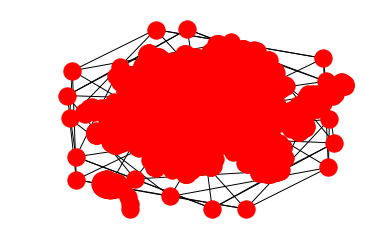

In [15]:
# Unweighted graph
nx.draw_networkx(unweighted_graph, arrows=True, with_labels=False)
G=nx.icosahedral_graph()    
nx.draw(G)
nx.draw(G,pos=nx.spring_layout(G))
plt.show()

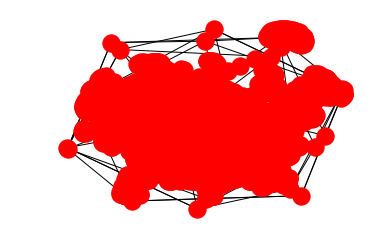

In [16]:
# Weighted graph
nx.draw_networkx(weighted_graph, arrows=True, with_labels=False)
G=nx.icosahedral_graph()    
nx.draw(G)
nx.draw(G,pos=nx.spring_layout(G))
plt.show()

## DISTANCE MATRICES

In [23]:
# Computing distance matrices for both cases
start = time.time()
if not(os.path.exists('./../data/graph/unweighted_dist_matrix.npy')):
    unweighted_matrix = calculate_dist_matrix(unweighted_graph, list(drugs.keys()))
    numpy.save('./../data/graph/unweighted_dist_matrix.npy', unweighted_matrix)
else: 
    unweighted_matrix = numpy.load('./../data/graph/unweighted_dist_matrix.npy')
print('Computed Unweighted Distance Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))  

if not(os.path.exists('./../data/graph/weighted_dist_matrix.npy')):
    weighted_matrix = calculate_weighted_dist_matrix(weighted_graph, list(drugs.keys()))
    numpy.save('./../data/graph/weighted_dist_matrix.npy', weighted_matrix)
else: 
    weighted_matrix = numpy.load('./../data/graph/weighted_dist_matrix.npy')
print('Computed Weighted Distance Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))  

Computed Unweighted Distance Matrix
Execution Time (s): 0.00638127326965332
Computed Weighted Distance Matrix
Execution Time (s): 0.012677907943725586


In [24]:
# We need to normalize the distance matrix and then compute the similarity matrix (needed for the SpectralClustering)
start = time.time()
if not(os.path.exists('./../data/graph/unweighted_sim_matrix.npy')) or not(os.path.exists('./../data/graph/norm_unweighted_sim_matrix.npy')):
    unweighted_sim_matrix = leakcock_chodorow_measure(unweighted_matrix)
    norm_unweighted_sim_matrix = normalize_matrix(unweighted_sim_matrix)
    numpy.save('./../data/graph/unweighted_sim_matrix.npy', unweighted_sim_matrix)
    numpy.save('./../data/graph/norm_unweighted_sim_matrix.npy', norm_unweighted_sim_matrix)
else: 
    unweighted_sim_matrix = numpy.load('./../data/graph/unweighted_sim_matrix.npy')
print('Computed Unweighted Similarity Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))

if not(os.path.exists('./../data/graph/weighted_sim_matrix.npy')) or not(os.path.exists('./../data/graph/norm_weighted_sim_matrix.npy')):
    weighted_sim_matrix = leakcock_chodorow_measure(weighted_matrix)
    norm_weighted_sim_matrix = normalize_matrix(weighted_sim_matrix)
    numpy.save('./../data/graph/weighted_sim_matrix.npy', weighted_sim_matrix)
    numpy.save('./../data/graph/norm_weighted_sim_matrix.npy', norm_weighted_sim_matrix)
else: 
    weighted_sim_matrix = numpy.load('./../data/graph/weighted_sim_matrix.npy')
print('Computed Weighted Similarity Matrix')
end = time.time()
print("Execution Time (s): " + str(end - start))

Computed Unweighted Similarity Matrix
Execution Time (s): 14.321918725967407
Computed Weighted Similarity Matrix
Execution Time (s): 28.82110834121704


## CLUSTERING

In [29]:
# Spectral Clustering
nclust = 14

sca_uw = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_uw.fit(norm_unweighted_sim_matrix)

sca_w = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_w.fit(norm_weighted_sim_matrix)

/usr/lib/python3/dist-packages/scipy/sparse/csgraph/_laplacian.py:71: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=14, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [30]:
# Extracting the clusters
clusters_idx_uw = label_idx(sca_uw.labels_, nclust)
clusters_idx_w = label_idx(sca_w.labels_, nclust)

clusters_dbid_uw = dict()
clusters_dbid_w = dict()

for l in clusters_idx_uw.keys():
     clusters_dbid_uw[l] = idx_to_id(clusters_idx_uw[l], ids_dic)
        
for l in clusters_idx_w.keys():
     clusters_dbid_w[l] = idx_to_id(clusters_idx_w[l], ids_dic)

In [31]:
# Printing the clusters
print('Number of clusters: ', nclust)
print('Clusters for Unweighted Graph:\n ', clusters_dbid_uw)

Number of clusters:  14
Clusters for Unweighted Graph:
  {0: ['DB00006', 'DB00027', 'DB00050', 'DB00118', 'DB00170', 'DB00179', 'DB00193', 'DB00194', 'DB00206', 'DB00228', 'DB00234', 'DB00242', 'DB00243', 'DB00247', 'DB00248', 'DB00249', 'DB00254', 'DB00255', 'DB00256', 'DB00257', 'DB00266', 'DB00269', 'DB00285', 'DB00289', 'DB00295', 'DB00309', 'DB00318', 'DB00320', 'DB00321', 'DB00327', 'DB00332', 'DB00337', 'DB00344', 'DB00353', 'DB00361', 'DB00379', 'DB00385', 'DB00403', 'DB00412', 'DB00423', 'DB00424', 'DB00432', 'DB00434', 'DB00435', 'DB00440', 'DB00441', 'DB00442', 'DB00445', 'DB00449', 'DB00453', 'DB00461', 'DB00468', 'DB00471', 'DB00476', 'DB00494', 'DB00495', 'DB00497', 'DB00498', 'DB00514', 'DB00515', 'DB00525', 'DB00533', 'DB00539', 'DB00540', 'DB00541', 'DB00553', 'DB00560', 'DB00570', 'DB00571', 'DB00572', 'DB00595', 'DB00602', 'DB00605', 'DB00611', 'DB00615', 'DB00618', 'DB00626', 'DB00631', 'DB00638', 'DB00640', 'DB00644', 'DB00647', 'DB00649', 'DB00652', 'DB00653', 'DB

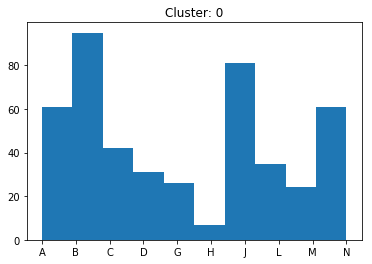

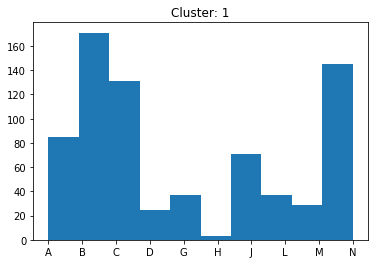

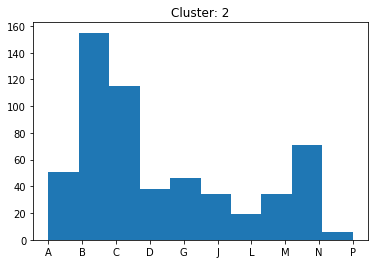

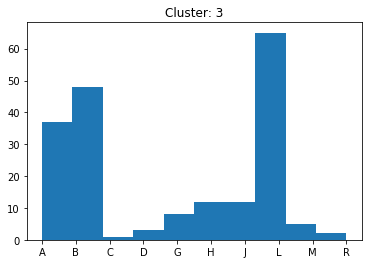

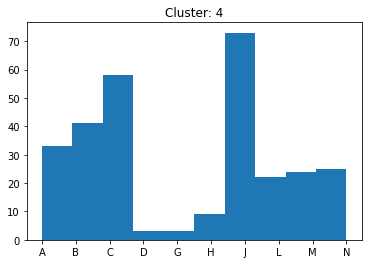

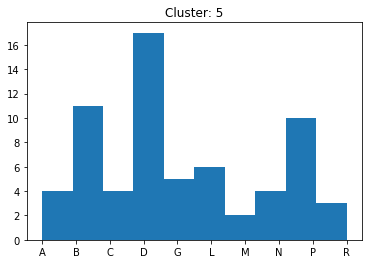

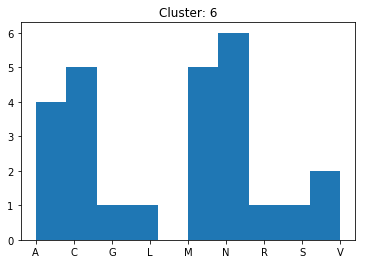

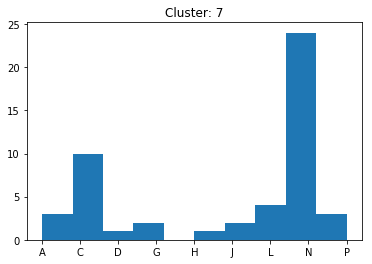

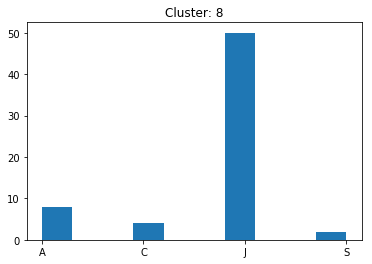

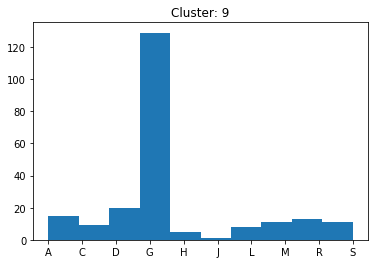

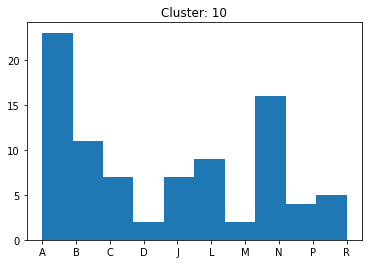

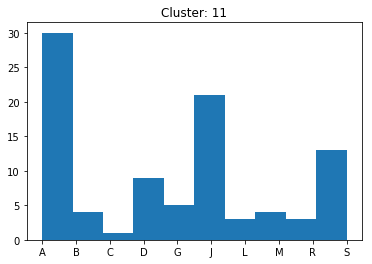

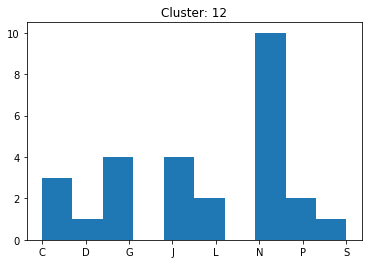

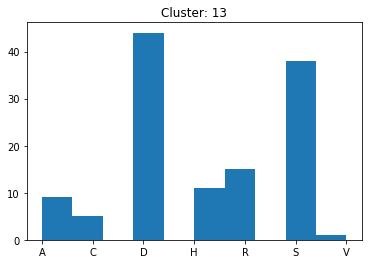

In [34]:
# Clusters ATC code distribution for Unweighted Graph
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_uw.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
#print(clusters_ATC_distribution)

for i in range (0, len(clusters_ATC_distribution)):
    plt.figure()
    plt.hist(clusters_ATC_distribution[i])
    plt.title('Cluster: %d' %i)
    plt.show

In [32]:
# Printing the clusters
print('Number of clusters: ', nclust)
print('Clusters for Weighted Graph:\n ', clusters_dbid_w)

Number of clusters:  14
Clusters for Weighted Graph:
  {0: ['DB00006', 'DB00027', 'DB00050', 'DB00080', 'DB00091', 'DB00114', 'DB00118', 'DB00121', 'DB00140', 'DB00150', 'DB00165', 'DB00170', 'DB00175', 'DB00176', 'DB00179', 'DB00183', 'DB00184', 'DB00185', 'DB00186', 'DB00191', 'DB00193', 'DB00194', 'DB00195', 'DB00196', 'DB00203', 'DB00204', 'DB00206', 'DB00208', 'DB00211', 'DB00213', 'DB00214', 'DB00215', 'DB00216', 'DB00217', 'DB00219', 'DB00221', 'DB00222', 'DB00228', 'DB00231', 'DB00233', 'DB00234', 'DB00235', 'DB00239', 'DB00242', 'DB00243', 'DB00244', 'DB00247', 'DB00248', 'DB00249', 'DB00250', 'DB00254', 'DB00255', 'DB00256', 'DB00257', 'DB00259', 'DB00262', 'DB00263', 'DB00264', 'DB00266', 'DB00268', 'DB00269', 'DB00270', 'DB00271', 'DB00273', 'DB00275', 'DB00280', 'DB00281', 'DB00282', 'DB00285', 'DB00289', 'DB00290', 'DB00295', 'DB00305', 'DB00308', 'DB00309', 'DB00313', 'DB00315', 'DB00316', 'DB00318', 'DB00320', 'DB00321', 'DB00323', 'DB00325', 'DB00327', 'DB00328', 'DB00

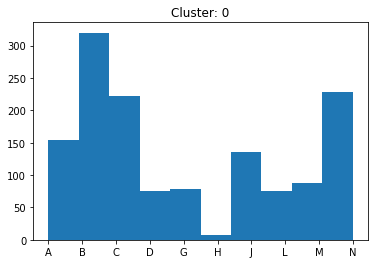

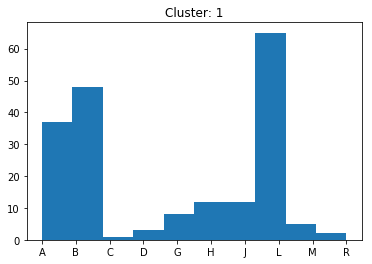

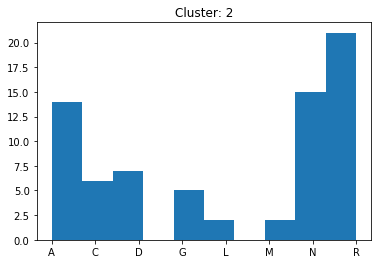

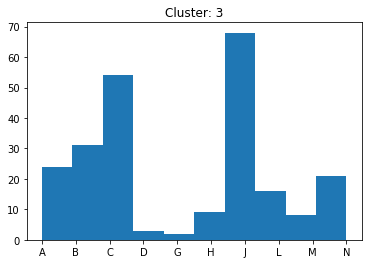

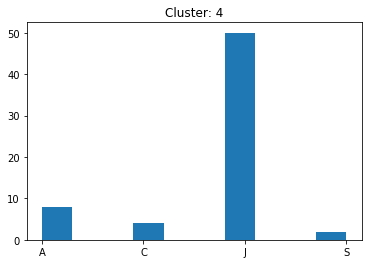

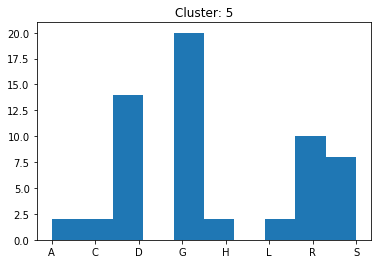

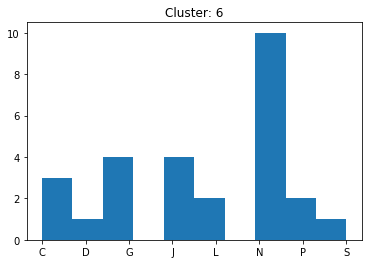

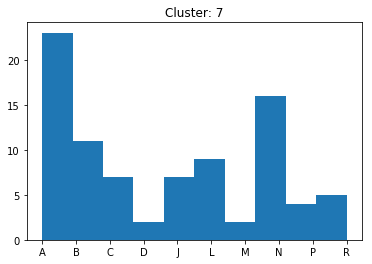

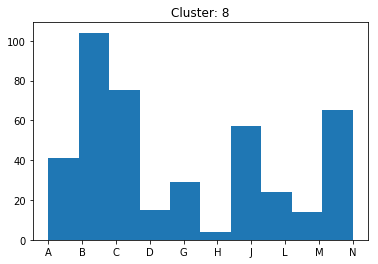

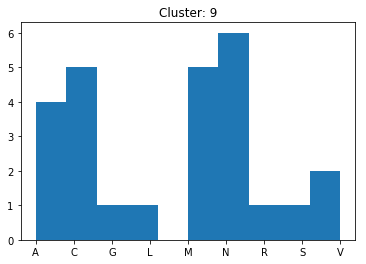

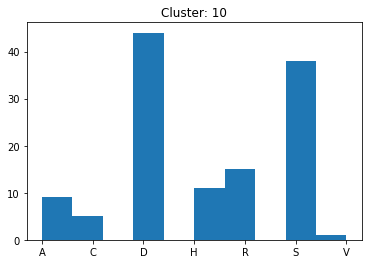

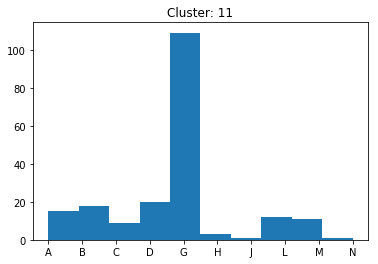

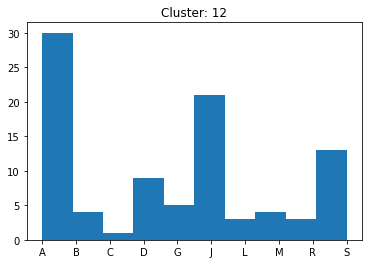

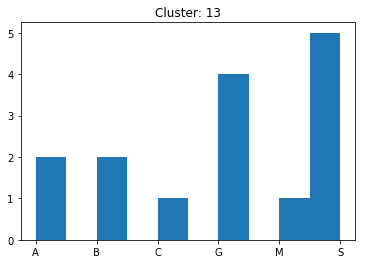

In [35]:
# Clusters ATC code distribution for Unweighted Graph
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_w.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
#print(clusters_ATC_distribution)

for i in range (0, len(clusters_ATC_distribution)):
    plt.figure()
    plt.hist(clusters_ATC_distribution[i])
    plt.title('Cluster: %d' %i)
    plt.show

## VISUALIZATION - SIMILARITY MATRICES

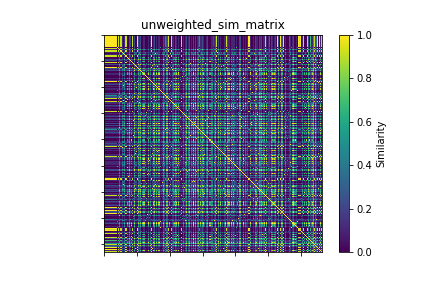

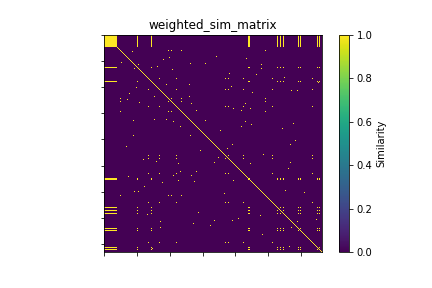

In [41]:
# Visual evaluation of Similarity
path_images = './../plots/graph/'

if not(os.path.exists('./../plots/graph/unweighted_sim_matrix.png')):
    save_similarity_matrix(numpy.array(unweighted_sim_matrix), path_images, \
                       'unweighted_sim_matrix')
else: 
    img = Image(filename = path_images + "unweighted_sim_matrix.png", width=500, height=500)
    display(img)
    
if not(os.path.exists('./../plots/graph/weighted_sim_matrix.png')):
    save_similarity_matrix(numpy.array(weighted_sim_matrix), path_images, \
                       'weighted_sim_matrix')
else: 
    img = Image(filename = path_images + "weighted_sim_matrix.png", width=500, height=500)
    display(img)

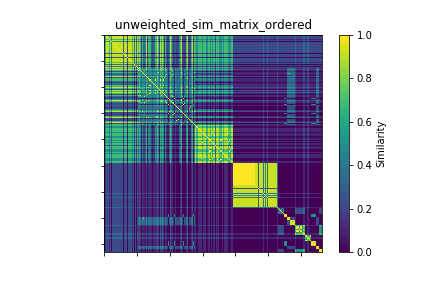

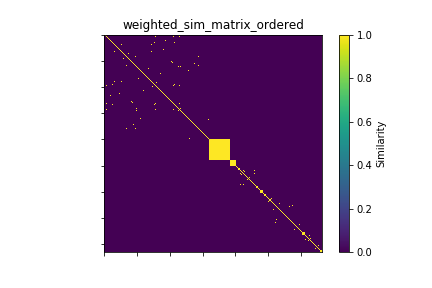

In [40]:
# Order the similarity matrices according to clusters
path_images = './../plots/graph/'

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_uw[i]
    
if not(os.path.exists('./../plots/graph/unweighted_sim_matrix_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(unweighted_sim_matrix), clusters_idx_ordered, \
                                   path_images, 'unweighted_sim_matrix_ordered')
else: 
    img = Image(filename = path_images + "unweighted_sim_matrix_ordered.png", width=500, height=500)
    display(img)

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_w[i]
if not(os.path.exists('./../plots/graph/weighted_sim_matrix_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(weighted_sim_matrix), clusters_idx_ordered, \
                                   path_images, 'weighted_sim_matrix_ordered')
else: 
    img = Image(filename = path_images + "weighted_sim_matrix_ordered.png", width=500, height=500)
    display(img)